# Correction of on-axis field with magnet displacements
---

This example introduces the concept of magntic field errors in undulators and presents a correction algorithm as described in [Calvi et al.](https://doi.org/10.1107/S1600577518002205)


In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.append('D:/Radia/env/radia_python/')  # chage this to the location on your machine
import radia as rad

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib import colors

In [2]:
# get help for Radia functions
help(rad.FldInt)

Help on built-in function FldInt in module radia:

FldInt(...)
    FldInt(obj,'inf|fin','ibx|iby|ibz'|'',[x1,y1,z1],[x2,y2,z2]) computes magnetic field induction integral produced by the object obj along a straight line specified by points [x1,y1,z1] and [x2,y2,z2]; depending on the second variable value, the integral is infinite ('inf') or finite from [x1,y1,z1] to [x2,y2,z2] ('fin'); the field integral component is specified by the third input variable. The units are Tesla x millimeters.



## helper functions
---

In this section a few helper functions will be introduced.

In [29]:
xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])
origin = np.array([0,0,0])

# physical constants
mc2 = 1e-6 * (pc.m_e*pc.c**2)/pc.elementary_charge # MeV. electron mass

#
# ===== helper functions =====
#

def rgb_color(value, cmapname='viridis'):
    """ returns the RGB values of the color from the colormap specified with scaled value.
    value - between 0 and 1
    cmapname='viridis' name of the colormap
    """ 
    cmap = ScalarMappable(cmap=cmapname)
    return list(cmap.to_rgba(value, bytes=False, norm=False)[:-1])

def rot_mat(angle, dim=3, axis='z'):
    """ Create a rotation matrix for rotation around the specified axis.
    """
    # sine cosine
    c = np.cos(angle)
    s = np.sin(angle)

    if dim == 3:
        if axis == 'x':
            rr = np.array( [[1, 0, 0], 
                            [0, c, -s], 
                            [0, s, c]] )
        elif axis == 'y':
            rr = np.array( [[c, 0, s], 
                            [0, 1, 0], 
                            [-s, 0, c]] )
        elif axis == 'z':
            rr = np.array( [[c, -s, 0], 
                            [s, c, 0], 
                            [0, 0, 1]] )
    elif dim == 2:
        rr = np.array( [[c, -s], 
                        [s, c]] )
    else:
        print(' error: `dim` variable must be 2 or 3. Specifies the dimension of the vectors that the rotation is acting on.')
    return rr

def magvec(transdir, jj, magmag, angerr=0.0, angerrstd=0.0, rngseed=None):
    """ Creates a 3D vector that represents the magnetization of a magnet of the specified undulaotr array.
    transdir - '-x','+x','-z','+z'. transverse dirction orientation of magnet array 
    jj - the magnet along that array for which the magnetization vec is created
    magmag - magnitude of magnetization
    angerr = 0.0. float. radians. error in angle of mag vector.
    angerrstd = 0.0 float. radians. st. dev. of mag vector angle
    rngseed = int. seed for the random number generator used with angerr and angerrstd

    outline:
     - start with unit z vector
     - apply error in angle
         - phi is uniform in [0,2pi]
         - theta is normal around angerr with angerrstd spread.
     - rotate to x, y, z
         - if error in magnetization angle is zero, the result will be in x,y,z directions

    NOTE: The longitudinal direction in Radia is the y-axis.
    """
    

    # error in magnetization direction
    if (angerr != 0.0) or (angerrstd > 0.0):
        
        rng = np.random.default_rng(rngseed)
        # phi is uniform in 2 pi
        phi = rng.random() * 2 * pc.pi
        # theta is Gaussian around angerr
        theta =  rng.normal(loc=angerr, scale=angerrstd)
        rtheta = rot_mat(-theta, dim=3, axis='x')
        rphi = rot_mat(phi, dim=3, axis='z')

        # unit magnetization vector
        mvec = np.matmul(rphi, np.matmul(rtheta, zhat))
    else:
        mvec = zhat

    # define 90 deg rotations around x,y and the identity for keeping zhat
    rx = rot_mat(pc.pi/2, dim=3, axis='x')
    ry = rot_mat(-pc.pi/2, dim=3, axis='y')
    r0 = np.eye(3)

    if transdir == '-x':
        ii = jj
        # note the x directionality
        rotii = (np.sin((pc.pi/2) * ii) * ry - np.cos((pc.pi/2) * ii)  * rx)
    elif transdir == '+x':
        ii = jj
        # note the x directionality
        rotii = (np.sin((pc.pi/2) * ii) * ry + np.cos((pc.pi/2) * ii)  * rx)

    elif transdir == '-z':
        # the x and z arrays are shifted by 90deg from the other
        ii = jj + 1
        # note the z directionality 
        rotii = (np.sin((pc.pi/2) * ii) * r0 - np.cos((pc.pi/2) * ii)  * rx)
    elif transdir == '+z':
        # the x and z arrays are shifted by 90deg from the other
        ii = jj + 1
        # note the z directionality 
        rotii = (np.sin((pc.pi/2) * ii) * r0 + np.cos((pc.pi/2) * ii)  * rx)

    # magnetization vector of the iith magnet block
    mvec = magmag * np.matmul(rotii, mvec)

    return mvec

def calc_kund(bcomp0, period):
    """ Calculates the undulator parameter K_und for the given magnetic field component.
        
        NB: planer undulator - K_und_x =  ( (period / (2 * pi) ) * B_x_0 * e ) / (m_e * c)
        for a helical undulator - K_und = sqrt( K_und_x**2 + K_und_y**2)
        
        bcomp0 - (T) the on-axis magnetic field component. can be ndarray
        period - (m) period of the undulator. can be ndarray.
        
        NB: if bcomp0 and period are ndarrays, it is prudent that they are of the same shape for valid results.
        
    """

    kund = bcomp0 * (pc.e / (pc.m_e * pc.c) ) * (period / ( 2 * pc.pi) )
    return kund



## Make undulator geometry
---

For this example, we will build a helical permanent magnet (PM) undulator based on the design by [Park et al.](https://doi.org/10.18429/JACOW-FEL2017-MOP011) for the TESSA-266 project. The Tapering Enhanced Stimulated Superradiant Amplification (TESSA) technique seeks to build a highly efficient FEL (>10% extraction) based on a strongly tapered undulator and prebunched electron beams.

In the following section we will develop a full Radia model of the undulator. 

In [30]:

class Poly2D():

    def __init__(self):
        self.PTS = np.array([])

    def trap(self, rin, rout, angle, coat):
        """
        Creates a 2 D polygon that reprsents a trapezoidal cross-section. 
        
        rin - inner radius.
        rout - outer radius.
        ang - angle subtended by wedge segment. if there are 8 wedges, the angle should be 2 [Pi]/8 = 45 deg.
        coat - thickness of the coating layer.

        output:
        pointlist - ndarray. must be converted to list if used in rad.Obj* functions. 
            use np.ndarray.tolist()
        """
        rincoat = rin + coat
        routcoat = rout + coat
        pointlist = np.array([
                [rincoat * np.cos(-angle/2), rincoat * np.sin(-angle/2)],
                [rincoat * np.cos(angle/2), rincoat * np.sin(angle/2)],
                [routcoat * np.cos(angle/2), routcoat * np.sin(angle/2)],
                [routcoat * np.cos(-angle/2), routcoat * np.sin(-angle/2)] ])
        
        ycoat = coat * np.tan(angle/4)
        coatarr = np.array([[0.0, ycoat],
                            [0.0, -ycoat],
                            [0.0, -ycoat],
                            [0.0, ycoat]])
        
        pointlist = pointlist + coatarr

        self.PTS = pointlist

        return pointlist

    def polytessa(self, gap, width1, width2, width3, height1, height2, transdir='-z'):
        """ Creates a polygon that is the cross-section of the undulator magnets in the TESSA undulators.
        The polygon is a hexagon with a narrow side toward the gap and a wide side opposite it. 
        
        gap - (mm) full gap of the undulator 
        width1, width2, width3, height1, height2 - (mm) dimensions of the polygon

        !!! NB: x-z are flipped because of the right-hand rule to keep the y axis as the longitudinal axis in Radia. Therefore, when plotting the polygon in 2D remember that the axes are flipped.
        """

        pointlist = np.array([[-gap/2, width1], 
                            [-(gap/2 + height1), width2], 
                            [-(gap/2 + height2), width3], 
                            [-(gap/2 + height2), -width3], 
                            [-(gap/2 + height1), -width2], 
                            [-gap/2, -width1]])

        if transdir == '-x':
            pointlist = np.transpose(np.matmul(rot_mat(-pc.pi/2, dim=2), np.transpose(pointlist)))
        elif transdir == '+x':
            pointlist = np.transpose(np.matmul(rot_mat(pc.pi/2, dim=2), np.transpose(pointlist)))
        elif transdir == '+z':
            pointlist = np.transpose(np.matmul(rot_mat(pc.pi, dim=2), np.transpose(pointlist)))

        self.PTS = pointlist

        return pointlist


class MagBlock():

    def __init__(self):
        
        # pts list describing the cross section polygon of the magnet blocks 
        self.POLY = np.array([])
        
        # undulator parameters
        
        self.THICK = 0
        
        self.BREMNANT = 0
        self.MATERIAL = 0
        
        # angular error in magnet block magnetization
        self.ANGERR = 0.0
        self.ANGERRSTD = 0.0

        # subdivision of the magnet blocks in the x,y,z planes of local ref frame
        self.SUBDIV = [1,1,1]

        # RADIA
        self.OBJ = 0
        self.SOL = 0

        self.DATA00 = pd.DataFrame([])
        self.FLD = pd.DataFrame([])


    def make_obj(self, ycenter, thick, transdir, jj, bremnant, material, angerr=0, angerrstd=0, rngseed=None, subdiv=[1,1,1]):
        """ Make a RADIA container with a single magnet block. The block is a bottom magnet (-z) 
        NB: The polygonal cross-section must be specified outside of this method, by assigning ndarray(2,npts) to self.POLY. 

        ycenter - float. (mm) the center of mass of the block along the extrusion direction.
        thick - float. (mm) thickness in the extrusion direction of the magnet block
        
        transdir - '-x','+x','-z','+z'. transverse dirction orientation of magnet array 
        jj - the magnet along that array for which the magnetization vec is created
        bremnant - float. (T) remnant field of magnet blocks
        material - str. PM material for the magnet blocks known to RADIA e.g. 'NdFeB', 'SmCo5'
        
        angerr = 0.0. float. radians. error in angle of mag vector.
        angerrstd = 0.0 float. radians. st. dev. of mag vector angle

        subdiv=[1,1,1] the number of subdivisions of each magnet block in the x,y,z directions in the magnet's reference frame

        """
        #update
        self.THICK = thick
        self.BREMNANT = bremnant
        self.MATERIAL = material
        
        self.ANGERR = angerr
        self.ANGERRSTD = angerrstd

        self.SUBDIV = subdiv

        # container for magnet block
        magcont = rad.ObjCnt([])

        # magnetization of block
        mv = magvec(transdir, jj, self.BREMNANT, angerr=self.ANGERR, angerrstd=self.ANGERRSTD, rngseed=rngseed)
        
        # make the magnet as an extruded polygon
        magblock = rad.ObjThckPgn(ycenter, self.THICK, self.POLY.tolist(), 'y', mv)
        
        # make material
        magmat = rad.MatStd(self.MATERIAL, self.BREMNANT)
        # apply material to the magnet block
        rad.MatApl(magblock, magmat)
        
        # subdivide the magnet blocks
        rad.ObjDivMag(magblock, subdiv)
        
        # color
        colorRGB = ( np.max([0.0, np.dot(mv, xhat) ]) * np.array(rgb_color(0.1, cmapname='bwr')) 
                   + np.max([0.0, np.dot(mv, -1*xhat) ]) * np.array(rgb_color(0.9, cmapname='bwr'))
                   + np.max([0.0, np.dot(mv, yhat) ]) * np.array(rgb_color(0.5, cmapname='bwr'))
                   + np.max([0.0, np.dot(mv, -1*yhat) ]) * np.array(rgb_color(0.5, cmapname='bwr'))
                   + np.max([0.0, np.dot(mv, zhat) ]) * np.array(rgb_color(0.1, cmapname='bwr')) 
                   + np.max([0.0, np.dot(mv, -1*zhat) ]) * np.array(rgb_color(0.9, cmapname='bwr')) )
        colorRGB = list(np.clip(colorRGB, 0.0, 1.0))

        rad.ObjDrwAtr(magblock, colorRGB)

        # add magnet to container
        rad.ObjAddToCnt(magcont, [magblock])

        # update class OBJ attribute
        self.OBJ = magcont

        return 0

    def solve_model(self, precision, maxiter, verbose=True):
        """ Attempts to solve/relax the RADIA model.
        
        precition - precision goal. e.g. 0.00001
        maxiter - maximum number of iterations. e.g. 1000

        returns solution
        """
        maxiter = int(maxiter) # needs to be integer for rad.Solve()

        t1 = time.time()
        solution = rad.Solve(self.OBJ, precision, maxiter)
        t2 = time.time()
        if verbose:
            print('rad.Solve took {:5.2f} seconds'.format(*[t2-t1]))
        self.SOL = solution

        return solution

    def calc_fld(self, xmin, xmax, xres, ymin, ymax, yres, zmin, zmax, zres, bcomp='b'):
        """ Calculates the magnetic field in the rectangular region specified by the xyz limits

        bcomp='b' B-field component to compute. 'b' =all components or 'bx', 'by', 'bz'
        """

        # make mesh
        xvec = np.arange(xmin, xmax+xres, xres)
        yvec = np.arange(ymin, ymax+yres, yres)
        zvec = np.arange(zmin, zmax+zres, zres)
        xx, yy, zz = np.meshgrid(xvec, yvec, zvec, indexing='xy')
        xyzpts = np.concatenate(( xx.reshape((-1,1)), yy.reshape((-1,1)), zz.reshape((-1,1)) ), axis=1)

        # colculate the field at xyz points
        t1 = time.time()
        bfld = np.array(rad.Fld(self.OBJ, bcomp, xyzpts.tolist()))
        t2 = time.time()
        print('field computation took {:5.2f} seconds'.format(*[t2-t1]))
        
        
        # column names for dataframe
        if bcomp == 'b':
            cn = ['x', 'y', 'z', 'bx', 'by', 'bz']

        else:
            cn = ['x', 'y', 'z', bcomp]
            bfld = bfld.reshape((-1,1)) # need shape to be (n,1), not (n,).

        # combine coordinates and field values
        fldarr = np.concatenate((xyzpts, bfld), axis=1)

        # make dataframe
        flddf = pd.DataFrame(fldarr, columns=cn)
        # update self.fld
        self.FLD = flddf

        return flddf



class Und(MagBlock):
    """ This is the Und() class. It reprsents the full undulator and contains methods relevant to field calculations.
    """

    def __init__(self):
        
        # pts list describing the cross section polygon of the magnet blocks 
        self.POLY = {'-x':np.array([]), '+x':np.array([]), '-z':np.array([]), '+z':np.array([])}
        
        # undulator parameters
        self.NUMPER = 0
        self.PERIOD = 0
        self.GAP = 0
        self.BREMNANT = {'-x':np.array([]), '+x':np.array([]), '-z':np.array([]), '+z':np.array([])}
        self.BREMNANTEE = {'-x':np.array([]), '+x':np.array([]), '-z':np.array([]), '+z':np.array([])}

        self.MATERIAL = 0
        
        # angular error in magnet block magnetization
        self.ANGERR = 0.0
        self.ANGERRSTD = 0.0

        # subdivision of the magnet blocks in the x,y,z planes of local ref frame
        self.SUBDIV = [1,1,1]

        # RADIA
        self.OBJ = 0
        self.SOL = 0

        self.DATA00 = pd.DataFrame([])
        self.FLD = pd.DataFrame([])
    

    def make_und(self, numper, period, gap, gaptaper, bremnant, material, angerr=0, angerrstd=0, rngseed=None,gapoffset=None, subdiv=[1,1,1]):
        """ Make a RADIA container with the full undulator.
        Assumptions on the geometry and make of undulator:
         - 4 block Halbach array for each period
         - fully PM based. Not hybrid i.e. no steel poles


        numper - float. number of undulator periods
        period - float. (m) undulator period
        gap - float. (mm) full gap of the undulator for the first period
        gaptaper - ndarray. (mm) an array of the differences in gap from the first period. defines the tapring of the undulator. must be the same length as the number of magnet blocks i.e. define the gap for each magnet. e.g. np.arrray([0,0,0,0, 0.1,0.1,0.1,0.1, ...]) will mean that the 4 magnets in the first period have have defined by self.POLY and the magnets in the second period have an increase in gap of 0.1 mm. 

        bremnant - dict(4,ndarray). (T) remnant field of magnet blocks
        material - str. PM material for the magnet blocks known to RADIA e.g. 'NdFeB', 'SmCo5'
        angerr = 0.0. float. radians. error in angle of mag vector.
        angerrstd = 0.0 float. radians. st. dev. of mag vector angle
        rngseed = -1. If >=0 the ang errors of each magnet block are seeded so that result can be reproduced. If -1, no seed is passed to RNG and errors are not reproducible.
        gapoffset=None, ndarray with the offset of each magnetblock from the specified gap taper. 
        subdiv=[1,1,1] the number of subdivisions of each magnet block in the x,y,z directions in the magnet's reference frame       
        
        """

        # update class attributes
        self.NUMPER = numper
        self.PERIOD = period
        self.MAGPOS = {'x':[], 'z':[]}
        self.GAP = gap
        self.BREMNANT = bremnant
        self.MATERIAL = material
        
        self.ANGERR = angerr
        self.ANGERRSTD = angerrstd

        self.SUBDIV = subdiv

        # thickness of magnet block in y (longitudinal)
        # this assumes a 4 block Halbach array
        ythick = self.PERIOD/4
        
        # list of keys for the directions
        arrlist = list(self.POLY.keys())

        # make containers for the x and z arrays of magnets
        containerdict = {kk:rad.ObjCnt([]) for kk in arrlist}
        # make gap tapering vectors
        gaptapdirection = {'-x':np.array([0,1]), 
                    '+x':np.array([0,-1]),
                    '-z':np.array([-1,0]),
                    '+z':np.array([1,0])}

        
        for ii in range(4 * self.NUMPER):
            
            # y-center position of magnet block
            ycenter = self.PERIOD/8 + ii * ythick
            self.MAGPOS['x'].append(ycenter)
            self.MAGPOS['z'].append(ycenter)

            for jj,dd in enumerate(arrlist):

                if (self.POLY[dd].shape[0] == 0):
                    print('=====\n')
                    print('ERROR: The cross section of the magnets was not specified inside .POLY')
                    print('POLY is a dictionary that contains ndarrays with shape (npts, 2) that specify the cross-section polygons describing the extruded magnet blocks that make up the undulator. You can use Poly2D().polytessa()')
                    print('\n=====')

                    return 1
                
                # polygon temporary inside for loop 
                poly = self.POLY[dd]
                # apply gap tapering and gapoffset
                if gapoffset is None:
                    poly = poly + ( gaptaper[ii]  ) * gaptapdirection[dd]
                else:
                    poly = poly + ( gaptaper[ii] + gapoffset[dd][[ii]] ) * gaptapdirection[dd]
               
                # magnetization of block based on position in array
                if rngseed >= 0:
                    rngseedtemp = int(rngseed + ii*jj) # covert to integer
                elif rngseed is not None:
                    rngseedtemp = None # catches if user set rngseed to negative
                else:
                    pass

                mb_args = [ycenter, ythick, dd, ii, self.BREMNANT[dd][ii], self.MATERIAL]
                mb_kwargs = dict(angerr=self.ANGERR, angerrstd=self.ANGERRSTD, rngseed=rngseedtemp, subdiv=self.SUBDIV)
                magblock = MagBlock()
                magblock.POLY = poly
                magblock.make_obj(*mb_args, **mb_kwargs)

                # add magnet to container
                rad.ObjAddToCnt(containerdict[dd], [magblock.OBJ])
        
        contund = rad.ObjCnt([])

        rad.ObjAddToCnt(contund, [containerdict[dd] for dd in arrlist ])
        
        # update class OBJ attribute
        self.OBJ = contund

        return contund

    def add_end_correct(self, bremnant, rngseed=-1, gaptaper=np.zeros(9), gapoffset=None):
        """ Adds entrance and exit magnets to correct electron trajectories.

        bremnant - dict(4,ndarray). (T) remnant field of magnet blocks
        gaptaper - ndarray. similar to gaptaper in make_und(), specifies the delta-gap from self.gap for each magnet
        rngseed = -1. If >=0 the ang errors of each magnet block are seeded so that result can be reproduced. If -1, no seed is passed to RNG and errors are not reproducible.



        """

        self.BREMNANTEE = bremnant
        
        # list of keys for the directions
        arrlist = list(self.POLY.keys())

        # make containers for the x and z arrays of magnets
        containerdict = {kk:rad.ObjCnt([]) for kk in arrlist}
        # make gap tapering vectors
        gaptapdirection = {'-x':np.array([0,1]), 
                    '+x':np.array([0,-1]),
                    '-z':np.array([-1,0]),
                    '+z':np.array([1,0])}
        
        # thickness of magnet block in y (longitudinal)
        # this assumes a 4 block Halbach array
        ythick = self.PERIOD/4
        # end of full periods
        yend = self.NUMPER * self.PERIOD

        # thickness of end correction magnets
        ythvec = ythick * np.array([1/4, 1/2, 3/4, 1, 1, 1, 3/4, 1/2, 1/4])
        
        # centers of magnets note that the fractional mag blocks are not centered in the space for a full mag block
        ycenterx1 = ythick * np.arange(-3, 1, 1) - ythvec[:4] / 2
        ycenterx2 = yend + (ythick * np.arange(5)) + ythvec[4:] / 2
        ycenterz = np.concatenate( (ycenterx1, ycenterx2), axis=0)

        ycenterz1 = ythick * np.arange(-4, 1, 1) - ythvec[:5] / 2
        ycenterz2 = yend + (ythick * np.arange(4)) + ythvec[5:] / 2
        ycenterx = np.concatenate( (ycenterz1, ycenterz2), axis=0)

        for ii in range(9):
            
            for jj,dd in enumerate(arrlist):
               
                # polygon. 
                poly = self.POLY[dd]
                # apply gap tapering and offset
                if gapoffset == None:
                    poly = poly + ( gaptaper[ii]  ) * gaptapdirection[dd]
                else:
                    poly = poly + ( gaptaper[ii] + gapoffset[dd][[ii]] ) * gaptapdirection[dd]
                # must convert to list for RADIA use
                poly = poly.tolist()
                
                if rngseed >= 0:
                    rngseed1 = rngseed + ii*jj
                else:
                    rngseed1 = None

                # make the magnet as an extruded polygon
                if (dd == '-x') or (dd == '+x'):
                    # magnetization of block
                    mv = magvec(dd, ii-1, self.BREMNANTEE[dd][ii], angerr=self.ANGERR, angerrstd=self.ANGERRSTD, rngseed=rngseed1)
                    magblock = rad.ObjThckPgn(ycenterx[ii], ythvec[ii], poly, 'y', mv)

                elif (dd == '-z') or (dd == '+z'):
                    # magnetization of block
                    mv = magvec(dd, ii, self.BREMNANTEE[dd][ii], angerr=self.ANGERR, angerrstd=self.ANGERRSTD, rngseed=rngseed1)
                    magblock = rad.ObjThckPgn(ycenterz[ii], ythvec[ii], poly, 'y', mv)
                

                # material for the blocks
                magmat = rad.MatStd(self.MATERIAL, self.BREMNANTEE[dd][ii])
                # apply material to the magnet block
                rad.MatApl(magblock, magmat)
                
                # color
                colorRGB = ( np.max([0.0, np.dot(mv, xhat) ]) * np.array(rgb_color(0.1, cmapname='bwr')) 
                           + np.max([0.0, np.dot(mv, -1*xhat) ]) * np.array(rgb_color(0.9, cmapname='bwr'))
                           + np.max([0.0, np.dot(mv, yhat) ]) * np.array(rgb_color(0.5, cmapname='bwr'))
                           + np.max([0.0, np.dot(mv, -1*yhat) ]) * np.array(rgb_color(0.5, cmapname='bwr'))
                           + np.max([0.0, np.dot(mv, zhat) ]) * np.array(rgb_color(0.1, cmapname='bwr')) 
                           + np.max([0.0, np.dot(mv, -1*zhat) ]) * np.array(rgb_color(0.9, cmapname='bwr')) )
                # colorRGB = list(colorRGB / np.sqrt(np.dot(colorRGB, colorRGB)))
                colorRGB = list(np.clip(colorRGB, 0.0, 1.0))

                rad.ObjDrwAtr(magblock, colorRGB)

                # subdivide the magnet blocks
                rad.ObjDivMag(magblock, self.SUBDIV)

                # add magnet to container
                rad.ObjAddToCnt(containerdict[dd], [magblock])
        
        # add to self.OBJ 
        rad.ObjAddToCnt(self.OBJ, [containerdict[dd] for dd in arrlist ])

        # add to positions
        self.MAGPOS['x'] += ycenterx.tolist()
        self.MAGPOS['x'].sort()
        self.MAGPOS['z'] += ycenterz.tolist()
        self.MAGPOS['z'].sort()

        return 0

    def calc_onaxis(self, nextra=3, nptsperper=100, e_energy=0.1, etraj=False, verbose=True):
        """ Calculates the on-axis field and particle trajectory. The longitudinal span should span the entrance and exit well outside the undulator.

        nextra - int. number of extra undulator periods before and after the full-period section to define the longitudinal interval 
        nptsperper - int. number of points per period for the field and trajectory calculations
        e_energy = 0.1 float. [GeV] the energy of the on-axis electron for which the trajectory is computed
        etraj - False, bool. whether or not to calculate the electron trajectory starting on-axis.
        verbose = True, bool. whether to print extra info like 'calculation time' 

        """
        
        y0 = -nextra * self.PERIOD
        y1 = (nextra + self.NUMPER) * self.PERIOD

        # number of points for the field calculations. defined on a per period basis.
        npts = nptsperper * (2*nextra + self.NUMPER)

        # define 3D points on-axis
        yvec = np.linspace(y0, y1, npts)
        xyzlist = np.zeros((yvec.shape[0], 3))
        xyzlist[:,1] = yvec

        # calculate field at xyz
        t1 = time.time()
        bfld = np.array( rad.Fld( self.OBJ, 'b', xyzlist.tolist() ) )
        t2 = time.time()
        if verbose:
            print('field computation took {:5.2f} seconds'.format(*[t2-t1]))


        # make into DF
        coln = ['x', 'y', 'z', 'bx', 'by', 'bz']
        df1 = pd.DataFrame( np.concatenate( (xyzlist, bfld), axis=1 ), columns=coln )

        # compute the undulator parameter
        for bb in ['bx', 'by', 'bz']:
            df1['ku'+bb[-1] ] = calc_kund(df1[bb], 1e-3 * self.PERIOD)

        if etraj:
            # compute trajectory of the on-axis electron
            t1 = time.time()
            etrj = np.array(rad.FldPtcTrj(self.OBJ, e_energy, [0,0,0,0], [y0, y1], npts))
            t2 = time.time()
            if verbose:
                print('trajectory computation took {:5.2f} seconds'.format(*[t2-t1]))

            for ii, cn in enumerate(['ex', 'edx', 'ez', 'edz']):
                df1[cn] = etrj[:, ii+1]

        # update on-axis data
        self.DATA00 = df1.copy()

        return df1


In [31]:
def local_make_und(ANG_ERR, ANG_ERR_STD, GAP_OS, GAP_OS_EE, loadmags=False, UND_NUMPER=8, rngseed=-1):

    B_REM = {'-x':np.array([]), '+x':np.array([]), '-z':np.array([]), '+z':np.array([])}
    B_REM_EE = {'-x':np.array([]), '+x':np.array([]), '-z':np.array([]), '+z':np.array([])}

    # set B_REM 
    if not loadmags:
        brfake = 1.2
        
        for dd in ['-x','+x','-z','+z']:
            B_REM[dd] = np.array([brfake for _ in range(4*UND_NUMPER)])
            B_REM_EE[dd] = np.array([brfake for _ in range(9)])
    else:

        ANG_ERR = 0.0 * pc.pi/180
        ANG_ERR_STD = 0.0 * pc.pi/180
        
        dirname = r'data/raw/magnets/'
        filename = 'mag_pb_brem.csv'
        B_REM, B_REM_EE = load_mag_arrays(dirname+filename)
        

    pg = Poly2D()

    gap = 8 # range is 5.8 - 7.2 mm
    w1 = 4.40/2
    w2 = 16.4/2
    w3 = 22/2
    h1 = 8
    h2 = 40

    # init undulator
    und1 = Und()

    # assign polygons
    for dd in list(und1.POLY.keys()):
        und1.POLY[dd] = pg.polytessa(gap, w1, w2, w3, h1, h2, transdir=dd)

    # define undulator parameters
    UND_PER = 32
    # UND_GAP_TAPER = np.array([0*np.floor(ii/4) for ii in range(4*UND_NUMPER)]) 
    UND_GAP_TAPER = np.zeros([4*UND_NUMPER]) # zeros -> no tapering

    PM_MAT = "NdFeB"

    # subdivide the magnet blocks for relaxation procedure
    # MAG_SUBDIV=[1,3,3]
    MAG_SUBDIV=[1,1,1]
    
    # make the undulator
    cu = und1.make_und(UND_NUMPER, UND_PER, gap, UND_GAP_TAPER, B_REM, PM_MAT, ANG_ERR, ANG_ERR_STD, rngseed=rngseed, subdiv=MAG_SUBDIV, gapoffset=GAP_OS)
    _ = und1.add_end_correct(B_REM_EE, gapoffset=GAP_OS_EE, rngseed=rngseed)

    # solve model
    prec = 1e-3
    maxit = 1e2
    sol = und1.solve_model(prec, maxit,verbose=False)
    # print('=====')
    df1 = und1.calc_onaxis(nptsperper=20, verbose=False)
    # print('=====')
    
    return und1

## Linear response matrix
---


In [32]:


def calc_pole_kund(und):
    """
    Calculate the local K value for each quarter period. 
    Segmentation of the K parameter: integrate over the pole length

    """
    polepos = und.PERIOD/8 + (und.PERIOD/4) * np.arange(-5, 4*und.NUMPER + 5 +0.1, 1) 

    polekund = np.zeros((polepos.shape[0],2))

    for i,pp in enumerate(polepos):
        
        si0 = pp - und.PERIOD/8
        si1 = pp + und.PERIOD/8
        # slice only data points inside pole
        dfi = und.DATA00[(und.DATA00['y'] > si0) & (und.DATA00['y'] <= si1)]
        
        polekund[i] = [  np.trapz( dfi['bx'].to_numpy(), dfi['y'].to_numpy() )
                        ,np.trapz( dfi['bz'].to_numpy(), dfi['y'].to_numpy() )
                        ]
    # add in quadature for helical und
    ktemp = np.sqrt(polekund[:,0]**2 + polekund[:,1]**2)
    polenum = np.arange(0,len(polepos),1)
    und.polekund = np.c_[polekund,ktemp,polenum]

    return 0 

def response_linear(magdisp, kresponse):
    '''
    Finds the linear response for each row of kresponse.
    magdisp - ndarray of the displacement of the magnets
    kresponse - ndarray (number of magnets, len(magdisp)). Each row of the response array will yield a coefficient that represents how much the total k_und changes due to a displacement of the magnet.

    '''
    kresponse_lin = []
    # find the least-sq linear fit to the bcomp-u1 curve
    A = np.vstack([ magdisp, np.ones(magdisp.shape[0]) ]).T

    for p, kresp in enumerate(kresponse):
        grad, _ = np.linalg.lstsq(A, kresp, rcond=None)[0]
        kresponse_lin.append(grad)
    
    return kresponse_lin

def make_coeff_matrix(kresp, krespee, mdir=['-x','+x','-z','+z']):
    ''' Makes a matrix of the response coefficients from the kresp and krespee dictionaries.kresp
    '''
    kresp1 = [ kresp[ma] for ma in mdir ]
    kresp1 = np.row_stack(kresp1) 
    # print(kresp1.shape)
    krespee1 = [ krespee[ma] for ma in mdir ]
    krespee1 = np.row_stack(krespee1) 
    # print(krespee1.shape)
    respcoeffmat = np.row_stack( [kresp1, krespee1]) 
    return respcoeffmat

def make_gap_correct(kund_error, amat, undref, mdir=['-x','+x','-z','+z']):
    '''
    Makes gap offset dictionaries for input into `make_und` from k_und error vec and response matrix.return
    kund_error - ndarray
    amat - ndarray
    undref - radia object that serves as the reference undulator for parameters
    mdir=['-x','+x','-z','+z']
    '''
    
    amat_pinv = np.linalg.pinv(amat)
    gap_correction = -np.matmul(amat_pinv, kund_error) # `-` indicates that the block has to be moved opposite of the direction that produces the observed field in order to compensate 

    nmagmain = 4*undref.NUMPER
    nmagee = 9

    gapos = {}
    gaposee = {}
    for i,ma in enumerate(mdir):

        ni = i*nmagmain
        nf = (i+1)*nmagmain
        gapos[ma] = gap_correction[ni:nf]

        ni = 4*nmagmain + i*nmagee
        nf = 4*nmagmain + (i+1)*nmagee
        gaposee[ma] = gap_correction[ni:nf]

    return gapos, gaposee

## Response matrix for an ideal undulator
---


In [41]:
## define undulator parameters
UND_NUMPER = 8

ANG_ERR = 0.0 * pc.pi/180
ANG_ERR_STD = 0.0 * pc.pi/180

magdirlist = ['-x','+x','-z','+z']

GAP_OS = { ma:np.zeros(4*UND_NUMPER) for ma in magdirlist}

GAP_OS_EE = { ma:np.zeros(9) for ma in magdirlist }

und_ideal = local_make_und(ANG_ERR, ANG_ERR_STD, GAP_OS, GAP_OS_EE, loadmags=False, UND_NUMPER=UND_NUMPER)
calc_pole_kund(und_ideal)

# init the response coefficient matricies
npoles = und_ideal.polekund.shape[0]
K_RESP = { ma:np.zeros([4*UND_NUMPER, npoles]) for ma in magdirlist }
K_RESP_EE = { ma:np.zeros([9,npoles]) for ma in magdirlist }

# displacement of the magnet block
magdisp_min, magdisp_max, magdisp_step = -0.2, 0.2, 0.2
magdisp = np.arange(magdisp_min, magdisp_max+magdisp_step/2, magdisp_step)

tprint = time.time() # timing the calculations

for i,ma in enumerate(magdirlist):

    # response in the full period part of the undulator
    for j, kresp in enumerate(K_RESP[ma]):
        
        kresponse = []
        for k, md in enumerate(magdisp):

            GAP_OS[ma][j] = md

            undtemp = local_make_und(ANG_ERR, ANG_ERR_STD, GAP_OS, GAP_OS_EE, loadmags=False, UND_NUMPER=UND_NUMPER)
            calc_pole_kund(undtemp)
            
            # reset to zero offset
            GAP_OS[ma][j] = 0.0

            
            kresponse.append(np.around(undtemp.polekund[:,2] - und_ideal.polekund[:,2], decimals=6) ) 
        kresponse = np.array(kresponse)
        kresponse = kresponse.transpose()

        # linear response coefficients
        kresponse_lin = response_linear(magdisp, kresponse)
        K_RESP[ma][j] = kresponse_lin

        # delete stale Radia objects
        rad.UtiDelAll()

    print( ( 'finished '+ma+' array'
                +'\nelapsed time: {:5.2f} seconds'
                # +'\n---'
                ).format(*[1+j//4, time.time() - tprint ])
            )
    tprint = time.time()
    
    # response in the entrance+exit of the undulator
    for j, kresp in enumerate(K_RESP_EE[ma]):
        kresponse = []
        for k, md in enumerate(magdisp):

            GAP_OS_EE[ma][j] = md

            undtemp = local_make_und(ANG_ERR, ANG_ERR_STD, GAP_OS, GAP_OS_EE, loadmags=False, UND_NUMPER=UND_NUMPER)
            calc_pole_kund(undtemp)
            
            # reset to zero offset
            GAP_OS_EE[ma][j] = 0.0

            
            kresponse.append(np.around(undtemp.polekund[:,2] - und_ideal.polekund[:,2], decimals=6) ) 
        kresponse = np.array(kresponse)
        kresponse = kresponse.transpose()

        # linear response coefficients
        kresponse_lin = response_linear(magdisp, kresponse)
        K_RESP_EE[ma][j] = kresponse_lin

        # delete stale Radia objects
        rad.UtiDelAll()

    print( ( 'finished '+ma+' array'
                +'\nelapsed time: {:5.2f} seconds'
                # +'\n---'
                ).format(*[1+j//4, time.time() - tprint ])
            )
    tprint = time.time()

finished -x array
elapsed time:  8.00 seconds
finished -x array
elapsed time:  3.00 seconds
finished +x array
elapsed time:  8.00 seconds
finished +x array
elapsed time:  3.00 seconds
finished -z array
elapsed time:  8.00 seconds
finished -z array
elapsed time:  3.00 seconds
finished +z array
elapsed time:  8.00 seconds
finished +z array
elapsed time:  3.00 seconds


In [42]:
# make the response matrix
amat = make_coeff_matrix(K_RESP, K_RESP_EE)
amat.shape

(164, 43)

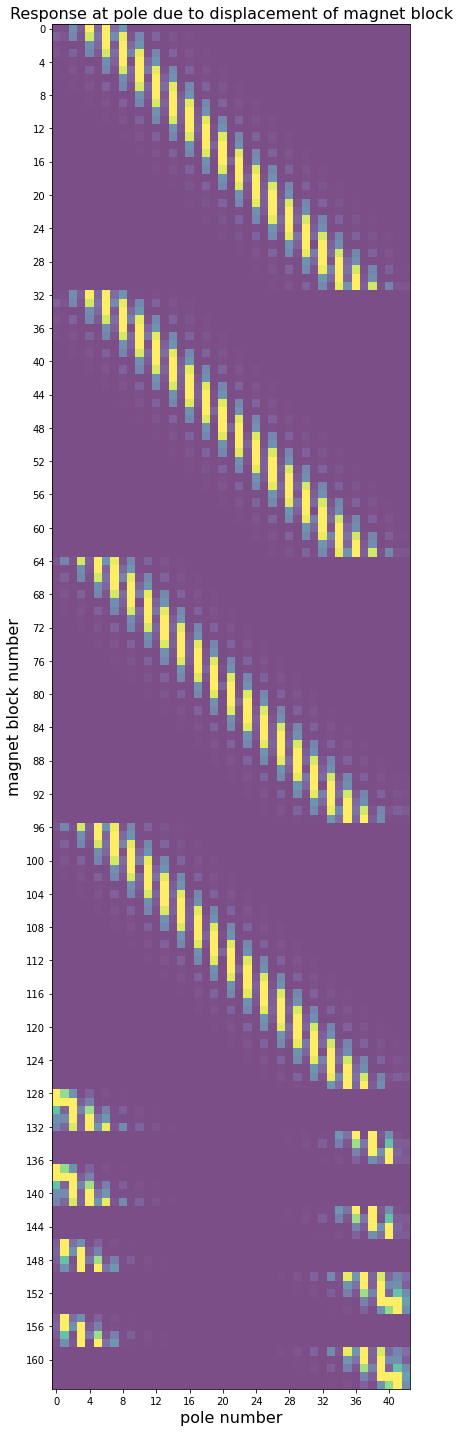

In [43]:

krtemp = np.abs(amat)
fig, ax = plt.subplots(figsize=(10,20))
im = ax.imshow(krtemp, cmap='viridis', vmin=0.0, vmax=0.01, aspect='equal', alpha=0.7 )

# show all ticks
ax.set_xticks(np.arange(0,krtemp.shape[1],4))
ax.set_yticks(np.arange(0,krtemp.shape[0],4))

fs = dict(fontsize=16)
plt.xlabel('pole number',**fs)
plt.ylabel('magnet block number', **fs)
ax.set_title("Response at pole due to displacement of magnet block", **fs)

    
fig.tight_layout()
plt.show()

# plt.show()

## Correct $K_{und}$ error
---
Invert the linear response matrix and apply the gap offsets that correct the errors in $K_{und}$.

As seen from the 2D representation of the response matrix in the above figure, the  

In [70]:
RNG_SEED = 42 # change this to see different randomizations of the individual magnetization errors

In [71]:
# magnetization errors for the individual magnet blocks. radians. see magvec() doc str.
ANG_ERR = 0.0 * pc.pi/180
ANG_ERR_STD = 3.0 * pc.pi/180
und_magangerr = local_make_und(ANG_ERR, ANG_ERR_STD, GAP_OS, GAP_OS_EE, rngseed=RNG_SEED, loadmags=False, UND_NUMPER=UND_NUMPER)
calc_pole_kund(und_magangerr)

0

In [72]:
kund_error = und_magangerr.polekund[:,2]-und_ideal.polekund[:,2]

GAP_CORR, GAP_CORR_EE = make_gap_correct(kund_error, amat.T, und_ideal)

In [73]:
ANG_ERR = 0.0 * pc.pi/180
ANG_ERR_STD = 3.0 * pc.pi/180
und_magangerr_corr = local_make_und(ANG_ERR, ANG_ERR_STD, GAP_CORR, GAP_CORR_EE, rngseed=RNG_SEED, loadmags=False, UND_NUMPER=UND_NUMPER)
calc_pole_kund(und_magangerr_corr)

0

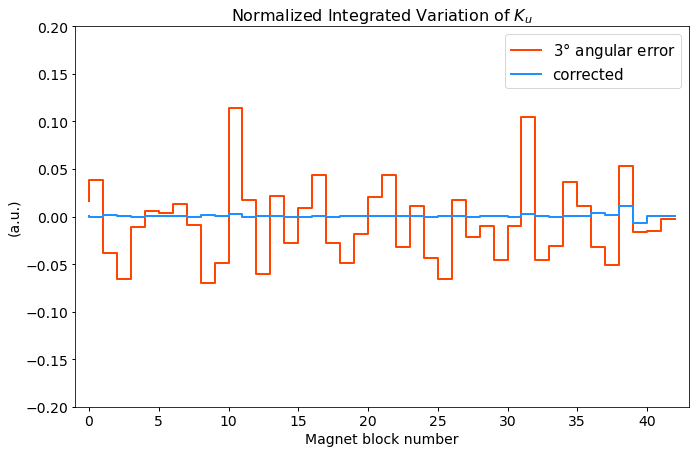

In [80]:
fig, ax = plt.subplots(figsize=(11,7))
ls = dict(linewidth=2,linestyle='-',marker='o',ms=0, alpha=1)


ls['color'] = 'orangered'
ax.step(und_ideal.polekund[:,3], und_magangerr.polekund[:,2]-und_ideal.polekund[:,2], **ls)
ls['color'] = 'dodgerblue'
ax.step(und_ideal.polekund[:,3], und_magangerr_corr.polekund[:,2]-und_ideal.polekund[:,2], **ls)
# 

ax.axis([-1,43, -0.2,0.2])


fs = dict(fontsize=14)
plt.xlabel('Magnet block number',**fs)
plt.ylabel('(a.u.)', **fs)
plt.title('Normalized Integrated Variation of $K_u$', fontsize=16)
legloc = 'best'
plt.legend(['$3 \\degree$ angular error ', 'corrected'], fontsize=15,loc=legloc)

ax.tick_params(labelcolor='k', labelsize=14, width=1)

ax.grid(False)
plt.show()

# phase errors
---

Equation 11 from Calvi et al.

$${\phi(s) = \frac{1}{\lambda_u(1 + K^2/2)} [s + (\frac{e}{mc})^2 \int_{0}^{s}{I^2(s')ds'}]}$$

where:

$$ I(s) = \int_{0}^{s}{B_{y}(s)ds} $$

In [109]:
def stepfunc(xvec, center, width, norm='max'):
    """
    Returns a step function with center and total width.
    xvec - ndarray of floats 
    center - float
    width - float. total width of box or step
    norm - {'max', 'area'} whether to normalize so that the maximum is unity or the area under the curve is unity
    """

    yvec = [ int((xx >= center - width/2) and (xx <= center + width/2)) for xx in xvec]
    if norm == 'area':
        normconstant = 1 / np.trapz(yvec, xvec)
    else:
        normconstant = 1

    return normconstant * yvec

def smooth(xvec, yvec, width, mode='gauss', edgemode='valid'):
    """
    xvec
    yvec
    
    width - float. if mode == 'gauss' width=std, if 'step' [center-width/2, center+width/2]
    mode - {'gauss','step', 'median'}
    edgemode = {'valid','pad'}
    to be used with gaussian or stepfunc

    When 'gauss' or 'step' filtering modes are used, both xvec and yvec are convolved with a gaussian or step function. The output x and y vecs are of shorter length because the 'valid' values begin at the point when the span of the convolution function (gauss/step) is inside the boundaries of the original xvec. 
    If the edgemode='valid' is used, then the output xvec and yvec are shorter than the input vectors, which may lead to problems when trying to compare initial to filtered signals. 
    The edgemode='pad' features aims to rectify this by padding the filtered yvec with the edge value on both sides, while keeping the original xvec values there. This method does introduce a discontinuity of the the derivative of the filtered signal.  
    """
    center = xvec.min() + (xvec.max() - xvec.min() ) / 2
    xstep = xvec[1]-xvec[0]
    xlen = xvec.shape[0]

    if mode in ['gauss', 'step']:
        wvec = 0
        if mode == 'gauss':
            nsig = 5
            xvectemp = np.arange(center - nsig * width, center + nsig * width + xstep, xstep)
            wvec = gaussian(xvectemp, center, width)
        elif mode == 'step':
            xvectemp = np.arange(center - width/2, center + width/2 + xstep, xstep)
            wvec = stepfunc(xvectemp, center, width)
        
        cnorm = 1 / (np.sum(wvec))
        # use mode='valid', otherwise edge/boundary values are not intuitive
        yvec = cnorm * np.convolve(yvec, wvec, mode='valid')
        
        ndiff = xlen - yvec.shape[0]
        if ndiff < 0:
            print('WARNING: `width` is larger than `xvec` span.')  
        if edgemode == 'pad':
            
            yvec = np.pad(yvec, [ndiff // 2, ndiff - ndiff // 2], mode='edge')

        elif edgemode == 'valid':
            xvec = cnorm * np.convolve(xvec, wvec, mode='valid') # done to match length of x and y vecs

    elif mode == 'median':
        yvec = sps.medfilt(yvec, kernel_size=width)
    else:
        print("ERROR: _mode_ must be 'gauss', 'step', or 'median' ")
        return 1


    return xvec, yvec

def calc_phase_error(svec, bvec, smax, eletoteng, undper, undk):
    '''
    svec - ndarray
    bvec - ndarray
    eletoteng - float. electron total energy
    '''
    gamma = eletoteng / mc2
    
    sveccut = svec[svec < smax]
    bveccut = bvec[:len(sveccut)]
    

    emc2 = (pc.elementary_charge / pc.m_e / pc.c)**2

    dsvec = np.diff(sveccut,n=1,prepend=(sveccut[1]-sveccut[0]))


    int1 = dsvec * np.cumsum(bveccut)

    phierr = ( (1 / (undper * (1 + undk**2 / 2) ) ) * ( (sveccut[-1] - sveccut[0]) + emc2 * np.trapz( np.array(int1)**2, sveccut ) ) )
    
    return phierr

In [154]:
E_ENG = 300 # total energy in MeV
TARGET_KUND = 2 #
for und in [und_ideal, und_magangerr,und_magangerr_corr]:
    svec =  1e-3*und.DATA00['y'].to_numpy()
    bvecx = und.DATA00['bx'].to_numpy()
    bvecz = und.DATA00['bz'].to_numpy()
    phivecbx = [0.0, 0.0] # init with 2 zeros matching length of svec
    phivecbz = [0.0, 0.0] # init with 2 zeros matching length of svec

    t1 = time.time()
    for s1 in svec[2:]:
        phivecbx.append( calc_phase_error(svec, bvecx, s1, E_ENG, 1e-3*und.PERIOD, TARGET_KUND) )
        phivecbz.append( calc_phase_error(svec, bvecz, s1, E_ENG, 1e-3*und.PERIOD, TARGET_KUND) )
    phivecbx = np.array(phivecbx)
    phivecbz = np.array(phivecbz)

    und.phase_error = np.c_[phivecbx,phivecbz]

    t2 = time.time()
    print('phi error took {:0.1f} seconds'.format(*[t2-t1]))


    yvec = und.phase_error[:,0]
    _, phifilterx = smooth(svec, yvec, 1e-3*und.PERIOD, mode='step', edgemode='pad')
    yvec = und.phase_error[:,1]
    _, phifiltery = smooth(svec, yvec, 1e-3*und.PERIOD, mode='step', edgemode='pad')
    und.phase_error_filtered = np.c_[phifilterx, phifiltery]

    print('phi error period filtered')
    und.totphierr = np.sum(und.phase_error_filtered)

phi error took 0.0 seconds
phi error period filtered
phi error took 0.0 seconds
phi error period filtered
phi error took 0.0 seconds
phi error period filtered


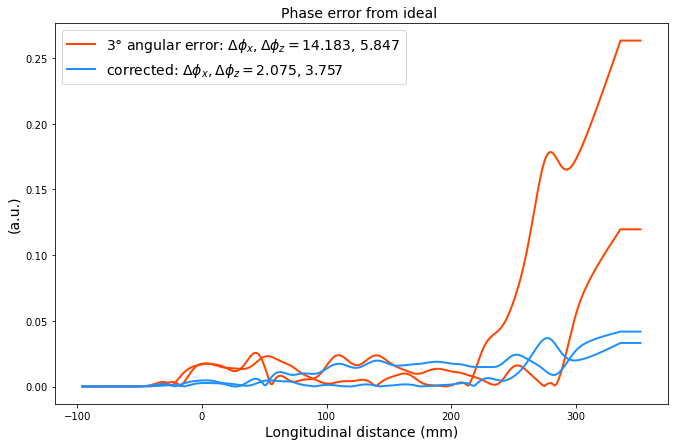

In [155]:
fig, ax = plt.subplots(figsize=(11,7))
ls = dict(linewidth=2,linestyle='-',marker='o',ms=0, alpha=1)

clist = ['orangered', 'dodgerblue']
leglabels = ['l1', 'l2']
leghandles = []
for i,und in enumerate([und_magangerr, und_magangerr_corr]):
    ls['color'] = clist[i]
    xvec = und.DATA00['y']
    # yvec = und.DATA00['bx']
    # ax.plot(xvec, yvec)

    yvec = np.abs(und.phase_error_filtered[:,0] - und_ideal.phase_error_filtered[:,0])
    dphix = np.sum(yvec)
    a1, = ax.plot(xvec, yvec, **ls, label=leglabels[i])
    leghandles.append(a1)
    yvec = np.abs(und.phase_error_filtered[:,1] - und_ideal.phase_error_filtered[:,1])
    dphiz = np.sum(yvec)
    ax.plot(xvec, yvec, **ls)

    und.dphi = [dphix,dphiz]

fs = dict(fontsize=14)
plt.xlabel('Longitudinal distance (mm)',**fs)
plt.ylabel('(a.u.)', **fs)
plt.title('Phase error from ideal ', fontsize=14)

legstr = [ '$3 \\degree$ angular error: $\Delta\phi_x , \Delta\phi_z = ${:0.3f}, {:0.3f}'.format(*und_magangerr.dphi)
          ,'corrected: $\Delta\phi_x , \Delta\phi_z = ${:0.3f}, {:0.3f}'.format(*und_magangerr_corr.dphi)  ]

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, legstr,fontsize=14,loc='best')
plt.grid(False)
# plt.yticks(np.arange(-1,12.4,1))
# plt.xticks(und_ideal.MAGPOS['x'])
plt.show()